# 名字生成任务

## 导入库和基础组件

In [12]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import itertools
import collections
import matplotlib.pyplot as plt
import math

# 位置编码
class NamePositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-math.log(10000.0) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

# 多头自注意力机制
class NameSelfAttention(nn.Module):
    def __init__(self, embed_size, heads, qk_dim):
        super().__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim_qk = qk_dim // heads
        self.head_dim_v = embed_size // heads

        assert qk_dim % heads == 0, "qk_dim 必须能被 heads 整除"
        assert embed_size % heads == 0, "embed_size 必须能被 heads 整除"

        self.query = nn.Linear(embed_size, qk_dim)
        self.key = nn.Linear(embed_size, qk_dim)
        self.value = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, query, key=None, value=None, mask=None):
        if key is None:
            key = query
        if value is None:
            value = query

        N = query.shape[0]
        query_len = query.shape[1]
        key_len = key.shape[1]
        value_len = value.shape[1]

        Q = self.query(query)
        K = self.key(key)
        V = self.value(value)

        Q = Q.view(N, query_len, self.heads, self.head_dim_qk).transpose(1, 2)
        K = K.view(N, key_len, self.heads, self.head_dim_qk).transpose(1, 2)
        V = V.view(N, value_len, self.heads, self.head_dim_v).transpose(1, 2)

        energy = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self.head_dim_qk)
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy, dim=-1)
        out = torch.matmul(attention, V)
        out = out.transpose(1, 2).contiguous().view(N, query_len, self.embed_size)
        out = self.fc_out(out)

        return out

# 测试位置编码和自注意力
print("测试名字生成的基础组件:")
pe = NamePositionalEncoding(embed_size=8, max_len=10)
test_input = torch.randn(2, 5, 8)
output = pe(test_input)
print(f"位置编码输入形状: {test_input.shape}")
print(f"位置编码输出形状: {output.shape}")

attention = NameSelfAttention(embed_size=8, heads=4, qk_dim=8)
test_input = torch.randn(2, 5, 8)
output = attention(test_input)
print(f"自注意力输入形状: {test_input.shape}")
print(f"自注意力输出形状: {output.shape}")

测试名字生成的基础组件:
位置编码输入形状: torch.Size([2, 5, 8])
位置编码输出形状: torch.Size([2, 5, 8])
自注意力输入形状: torch.Size([2, 5, 8])
自注意力输出形状: torch.Size([2, 5, 8])


## 前馈神经网络和Decoder Block

In [13]:
# 前馈神经网络
class NameFeedForward(nn.Module):
    def __init__(self, embed_size, hidden_dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(embed_size, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Decoder Block
class NameDecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, qk_dim, ff_hidden_size, dropout=0.1):
        super().__init__()
        self.self_attention = NameSelfAttention(embed_size, heads, qk_dim)
        self.norm1 = nn.LayerNorm(embed_size)
        self.dropout1 = nn.Dropout(dropout)

        self.feed_forward = NameFeedForward(embed_size, ff_hidden_size, dropout)
        self.norm2 = nn.LayerNorm(embed_size)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, tgt_mask=None):
        # Masked Self-Attention
        _x = self.self_attention(query=x, key=None, value=None, mask=tgt_mask)
        x = self.norm1(x + self.dropout1(_x))

        # Feed-Forward Network
        _x = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(_x))

        return x

# 测试前馈网络和Decoder Block
print("测试名字生成的前馈网络:")
ffn = NameFeedForward(embed_size=8, hidden_dim=16, dropout=0.1)
test_input = torch.randn(2, 5, 8)
output = ffn(test_input)
print(f"前馈网络输入形状: {test_input.shape}")
print(f"前馈网络输出形状: {output.shape}")

print("\n测试名字生成的Decoder Block:")
decoder_block = NameDecoderBlock(embed_size=8, heads=4, qk_dim=8, ff_hidden_size=16, dropout=0.1)
test_input = torch.randn(2, 5, 8)
# 创建下三角mask
mask = torch.tril(torch.ones((1, 5, 5)))
output = decoder_block(test_input, mask)
print(f"Decoder Block输入形状: {test_input.shape}")
print(f"Decoder Block输出形状: {output.shape}")
print(f"Mask形状: {mask.shape}")

测试名字生成的前馈网络:
前馈网络输入形状: torch.Size([2, 5, 8])
前馈网络输出形状: torch.Size([2, 5, 8])

测试名字生成的Decoder Block:
Decoder Block输入形状: torch.Size([2, 5, 8])
Decoder Block输出形状: torch.Size([2, 5, 8])
Mask形状: torch.Size([1, 5, 5])


## 名字生成的数据预处理函数

In [14]:
# 名字生成的数据预处理函数
def char2index(char, dict):
    return dict.index(char)

def name2index(name, dict):
    return [char2index(char, dict) for char in name]

def names2tensor(names, dict, charset_size):
    n = len(names)
    lens = [len(name) for name in names]
    max_len = max(lens)
    
    tensor = torch.zeros(max_len, n, charset_size)
    target = torch.zeros(max_len, n, dtype=int) + charset_size - 1
    
    for i in range(n):
        name = names[i]
        for j in range(len(name)):
            tensor[j, i, char2index(name[j], dict)] = 1
            if j < len(name) - 1:
                target[j, i] = char2index(name[j + 1], dict)
    
    return tensor, np.array(lens), target

# 测试名字生成的数据预处理函数
print("测试名字生成的数据预处理函数:")
test_dict = ['王', '李', '张', '刘', '陈', '伟', '娜', '强', '芳', '明']
test_names = ["王伟", "李娜", "张强"]

print(f"测试字典: {test_dict}")
print(f"测试名字: {test_names}")

char_idx = char2index('王', test_dict)
print(f"'王'在字典中的索引: {char_idx}")

name_indices = name2index("王伟", test_dict)
print(f"名字'王伟'的索引序列: {name_indices}")

input_tensor, actual_len, target_tensor = names2tensor(test_names, test_dict, len(test_dict))
print(f"输入张量形状: {input_tensor.shape}")
print(f"实际长度: {actual_len}")
print(f"目标张量形状: {target_tensor.shape}")
print(f"第一个名字的输入:\n{input_tensor[:, 0, :]}")
print(f"第一个名字的目标:\n{target_tensor[:, 0]}")

测试名字生成的数据预处理函数:
测试字典: ['王', '李', '张', '刘', '陈', '伟', '娜', '强', '芳', '明']
测试名字: ['王伟', '李娜', '张强']
'王'在字典中的索引: 0
名字'王伟'的索引序列: [0, 5]
输入张量形状: torch.Size([2, 3, 10])
实际长度: [2 2 2]
目标张量形状: torch.Size([2, 3])
第一个名字的输入:
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])
第一个名字的目标:
tensor([5, 9])


## Transformer Decoder和名字生成器

In [15]:
# Transformer Decoder
class NameTransformerDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_layers, heads, qk_dim,
                 ff_hidden_size, dropout=0.1, max_length=100):
        super().__init__()
        self.embed_size = embed_size

        self.word_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_encoding = NamePositionalEncoding(embed_size, max_length)

        self.layers = nn.ModuleList([
            NameDecoderBlock(embed_size, heads, qk_dim, ff_hidden_size, dropout)
            for _ in range(num_layers)
        ])

        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(embed_size, vocab_size)

    def forward(self, x, tgt_mask=None):
        out = self.word_embedding(x)
        out = self.position_encoding(out)
        out = self.dropout(out)

        for layer in self.layers:
            out = layer(out, tgt_mask)

        out = self.fc_out(out)
        return out

# 名字生成器
class NameGenerator(nn.Module):
    def __init__(self, vocab_size, embed_size, num_layers, heads, qk_dim, 
                 ff_hidden_size, dropout=0.1, max_length=100):
        super().__init__()
        self.decoder = NameTransformerDecoder(
            vocab_size, embed_size, num_layers, heads, qk_dim, 
            ff_hidden_size, dropout, max_length
        )
        self.max_length = max_length
        
    def forward(self, x, tgt_mask=None):
        return self.decoder(x, tgt_mask)
    
    def generate_name(self, start_char, dict, max_len=10, temperature=1.0):
        self.eval()
        with torch.no_grad():
            # 初始化输入
            if start_char in dict:
                start_idx = dict.index(start_char)
            else:
                start_idx = 0
            
            input_seq = [start_idx]
            current_input = torch.tensor([input_seq], dtype=torch.long)
            
            for _ in range(max_len - 1):
                # 创建mask
                seq_len = current_input.size(1)
                mask = torch.tril(torch.ones((1, seq_len, seq_len)))
                
                # 前向传播
                output = self(current_input, mask)
                next_token_logits = output[0, -1, :] / temperature
                
                # 采样下一个token
                probs = torch.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, 1).item()
                
                # 检查是否结束
                if next_token == len(dict):  # EOS token
                    break
                
                input_seq.append(next_token)
                current_input = torch.tensor([input_seq], dtype=torch.long)
            
            # 转换为字符
            generated_name = ''.join([dict[idx] for idx in input_seq])
            return generated_name

# 测试Transformer Decoder和名字生成器
print("测试名字生成的Transformer Decoder:")
decoder = NameTransformerDecoder(vocab_size=100, embed_size=8, num_layers=2, heads=4, 
                               qk_dim=8, ff_hidden_size=16, dropout=0.1, max_length=10)
test_input = torch.randint(0, 100, (2, 5))
mask = torch.tril(torch.ones((1, 5, 5)))
output = decoder(test_input, mask)
print(f"Decoder输入形状: {test_input.shape}")
print(f"Decoder输出形状: {output.shape}")

print("\n测试名字生成器:")
generator = NameGenerator(vocab_size=100, embed_size=8, num_layers=2, heads=4, 
                         qk_dim=8, ff_hidden_size=16, dropout=0.1, max_length=10)
test_input = torch.randint(0, 100, (2, 5))
output = generator(test_input, mask)
print(f"生成器输入形状: {test_input.shape}")
print(f"生成器输出形状: {output.shape}")

测试名字生成的Transformer Decoder:
Decoder输入形状: torch.Size([2, 5])
Decoder输出形状: torch.Size([2, 5, 100])

测试名字生成器:
生成器输入形状: torch.Size([2, 5])
生成器输出形状: torch.Size([2, 5, 100])


## 名字生成的数据预处理函数

In [16]:
# 名字生成的数据预处理函数
def name_gen_char2index(char, dict):
    return dict.index(char)

def name_gen_name2index(name, dict):
    return [name_gen_char2index(char, dict) for char in name]

def name_gen_names2tensor(names, dict, charset_size):
    n = len(names)
    lens = [len(name) for name in names]
    max_len = max(lens)
    
    tensor = torch.zeros(max_len, n, charset_size)
    target = torch.zeros(max_len, n, dtype=int) + charset_size - 1
    
    for i in range(n):
        name = names[i]
        for j in range(len(name)):
            tensor[j, i, name_gen_char2index(name[j], dict)] = 1
            if j < len(name) - 1:
                target[j, i] = name_gen_char2index(name[j + 1], dict)
    
    return tensor, np.array(lens), target

# 测试名字生成的数据预处理函数
print("测试名字生成的数据预处理函数:")
test_dict = ['王', '李', '张', '刘', '陈', '伟', '娜', '强', '芳', '明']
test_names = ["王伟", "李娜", "张强"]

print(f"测试字典: {test_dict}")
print(f"测试名字: {test_names}")

char_idx = name_gen_char2index('王', test_dict)
print(f"'王'在字典中的索引: {char_idx}")

name_indices = name_gen_name2index("王伟", test_dict)
print(f"名字'王伟'的索引序列: {name_indices}")

input_tensor, actual_len, target_tensor = name_gen_names2tensor(test_names, test_dict, len(test_dict))
print(f"输入张量形状: {input_tensor.shape}")
print(f"实际长度: {actual_len}")
print(f"目标张量形状: {target_tensor.shape}")
print(f"第一个名字的输入:\n{input_tensor[:, 0, :]}")
print(f"第一个名字的目标:\n{target_tensor[:, 0]}")

测试名字生成的数据预处理函数:
测试字典: ['王', '李', '张', '刘', '陈', '伟', '娜', '强', '芳', '明']
测试名字: ['王伟', '李娜', '张强']
'王'在字典中的索引: 0
名字'王伟'的索引序列: [0, 5]
输入张量形状: torch.Size([2, 3, 10])
实际长度: [2 2 2]
目标张量形状: torch.Size([2, 3])
第一个名字的输入:
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])
第一个名字的目标:
tensor([5, 9])


## 名字生成的数据准备函数

In [17]:
# 名字生成的数据准备函数
def prepare_name_data():
    # 读取数据
    df = pd.read_csv("English_Cn_Name_Corpus（48W）.txt", header=None, names=["name"], skiprows=2)
    names = df["name"].values
    
    # 计算单字频率
    chars = [list(name) for name in names]
    chars_flatten = list(itertools.chain(*chars))
    freq = collections.Counter(chars_flatten)
    freq = pd.DataFrame(freq.items(), columns=["char", "freq"])
    freq = freq.sort_values(by="freq", ascending=False)
    
    # 准备数据
    dict_size = 50
    charset_size = dict_size + 1  # 加1是为了EOS token
    dict = list(freq["char"].values[:dict_size])
    dict_set = set(dict)
    dat = list(filter(lambda name: set(name).issubset(dict_set), names))
    
    return dat, dict, charset_size

# 测试名字生成的数据准备函数
print("测试名字生成的数据准备函数:")
try:
    dat, dict, charset_size = prepare_name_data()
    print(f"数据大小: {len(dat)}")
    print(f"字典大小: {len(dict)}")
    print(f"字符集大小: {charset_size}")
    print(f"前10个常用字: {dict[:10]}")
    print(f"前5个名字示例: {dat[:5]}")
except FileNotFoundError:
    print("数据文件未找到，请确保文件路径正确")
    # 创建模拟数据用于测试
    print("创建模拟数据用于测试...")
    np.random.seed(123)
    mock_names = ['王伟', '李娜', '张强', '刘芳', '陈明', '赵美丽', '孙英俊'] * 100
    dat = mock_names
    dict = ['王', '李', '张', '刘', '陈', '赵', '孙', '伟', '娜', '强', '芳', '明', '美', '丽', '英', '俊']
    charset_size = len(dict) + 1
    
    print(f"模拟数据大小: {len(dat)}")
    print(f"模拟字典大小: {len(dict)}")
    print(f"模拟字符集大小: {charset_size}")
    print(f"前5个名字示例: {dat[:5]}")

测试名字生成的数据准备函数:
数据大小: 72247
字典大小: 50
字符集大小: 51
前10个常用字: ['尔', '斯', '拉', '克', '特', '德', '尼', '夫', '利', '科']
前5个名字示例: ['阿阿巴伊', '阿阿卡伊', '阿阿拉尔', '阿阿内尔', '阿阿韦尔迪']


## 名字生成的训练函数

开始训练名字生成器...
Epoch 0, Batch 0, Loss = 4.1854
Epoch 0, Batch 10, Loss = 3.7629
Epoch 0, Batch 20, Loss = 3.6587
Epoch 0, Batch 30, Loss = 3.6975
Epoch 0, Batch 40, Loss = 3.6374
Epoch 0, Batch 50, Loss = 3.5811
Epoch 0, Batch 60, Loss = 3.6112
Epoch 0, Batch 70, Loss = 3.5740
Epoch 0, Batch 80, Loss = 3.5480
Epoch 0, Batch 90, Loss = 3.5309
Epoch 0, Batch 100, Loss = 3.5954
Epoch 0, Batch 110, Loss = 3.4232
Epoch 0, Batch 120, Loss = 3.4217
Epoch 0, Batch 130, Loss = 3.5815
Epoch 0, Batch 140, Loss = 3.3685
Epoch 0, Batch 150, Loss = 3.4049
Epoch 0, Batch 160, Loss = 3.3655
Epoch 0, Batch 170, Loss = 3.2701
Epoch 0, Batch 180, Loss = 3.3293
Epoch 0, Batch 190, Loss = 3.3407
Epoch 0, Batch 200, Loss = 3.3446
Epoch 0, Batch 210, Loss = 3.3946
Epoch 0, Batch 220, Loss = 3.5094
Epoch 0, Batch 230, Loss = 3.5438
Epoch 0, Batch 240, Loss = 3.4672
Epoch 0, Batch 250, Loss = 3.4175
Epoch 0, Batch 260, Loss = 3.4202
Epoch 0, Batch 270, Loss = 3.4014
Epoch 0, Batch 280, Loss = 3.2756
Epoch 0, Bat

e:\DL\deeplearning\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21517 (\N{CJK UNIFIED IDEOGRAPH-540D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\DL\deeplearning\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23383 (\N{CJK UNIFIED IDEOGRAPH-5B57}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\DL\deeplearning\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\DL\deeplearning\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\DL\deeplearning\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\DL\deeplearning\L

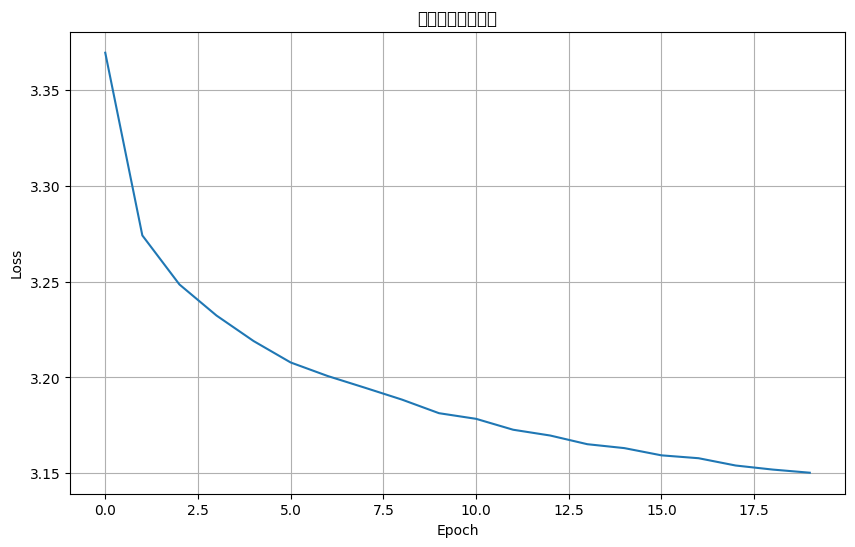

训练完成！


In [20]:
def train_name_generator(dat, dict, charset_size):
    # 模型参数
    vocab_size = charset_size
    embed_size = 64
    num_layers = 3
    heads = 8
    qk_dim = 64
    ff_hidden_size = 128
    dropout = 0.1
    max_length = 10
    
    # 创建模型
    model = NameGenerator(vocab_size, embed_size, num_layers, heads, qk_dim, 
                         ff_hidden_size, dropout, max_length)
    
    # 训练参数
    criterion = nn.CrossEntropyLoss(ignore_index=charset_size-1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # 训练循环
    nepoch = 20
    batch_size = 64
    losses = []
    
    for epoch in range(nepoch):
        model.train()
        total_loss = 0
        n_batches = 0
        
        # 随机打乱训练数据
        train_indices = np.random.permutation(len(dat))
        
        for i in range(0, len(dat), batch_size):
            batch_indices = train_indices[i:i+batch_size]
            batch_names = [dat[idx] for idx in batch_indices]
            
            # 转换为tensor
            input_tensor, actual_len, target_tensor = name_gen_names2tensor(batch_names, dict, charset_size)
            
            # 转换为模型输入格式 - 使用reshape避免内存布局问题
            input_indices = torch.argmax(input_tensor, dim=-1).transpose(0, 1)  # (batch_size, seq_len)
            target_indices = target_tensor.transpose(0, 1)  # (batch_size, seq_len)
            
            # 确保张量是连续的
            input_indices = input_indices.contiguous()
            target_indices = target_indices.contiguous()
            
            # 创建mask
            seq_len = input_indices.size(1)
            mask = torch.tril(torch.ones((1, seq_len, seq_len)))
            
            # 前向传播
            optimizer.zero_grad()
            output = model(input_indices, mask)
            
            # 计算损失 - 使用reshape而不是view
            batch_size_actual = output.size(0)
            seq_len_actual = output.size(1)
            output_reshaped = output.reshape(batch_size_actual * seq_len_actual, charset_size)
            target_reshaped = target_indices.reshape(batch_size_actual * seq_len_actual)
            
            loss = criterion(output_reshaped, target_reshaped)
            
            # 反向传播
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            n_batches += 1
            
            if i // batch_size % 10 == 0:
                print(f"Epoch {epoch}, Batch {i // batch_size}, Loss = {loss.item():.4f}")
        
        avg_loss = total_loss / n_batches
        losses.append(avg_loss)
        print(f"Epoch {epoch}, Average Loss = {avg_loss:.4f}")
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title("名字生成训练损失")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()
    
    return model

# 测试名字生成训练函数
print("开始训练名字生成器...")
try:
    model = train_name_generator(dat, dict, charset_size)
    print("训练完成！")
except Exception as e:
    print(f"训练过程中出现错误: {e}")

## 名字生成和测试

In [22]:
# 名字生成和测试
def generate_names(model, dict, num_names=10, max_len=8):
    """生成多个名字"""
    model.eval()
    generated_names = []
    
    # 获取姓氏
    family_names = list(set([name[0] for name in dict if len(name) > 0]))
    
    for _ in range(num_names):
        # 随机选择姓氏
        start_char = np.random.choice(family_names)
        generated_name = model.generate_name(start_char, dict, max_len)
        generated_names.append(generated_name)
    
    return generated_names

def test_name_generation(model, dict, max_len=8):
    """测试名字生成功能"""
    model.eval()
    test_start_chars = ["亚","马","基","维"]
    
    print("名字生成测试:")
    print("-" * 40)
    
    for start_char in test_start_chars:
        if start_char in dict:
            generated_name = model.generate_name(start_char, dict, max_len)
            print(f"起始字符: {start_char} | 生成名字: {generated_name}")
        else:
            print(f"起始字符: {start_char} | 不在字典中")

# 运行名字生成测试
try:
    print("生成多个名字:")
    generated_names = generate_names(model, dict, num_names=10, max_len=8)
    for i, name in enumerate(generated_names, 1):
        print(f"{i:2d}. {name}")
    
    print("\n" + "="*50)
    test_name_generation(model, dict, max_len=8)
    
except NameError:
    print("模型未训练，无法进行名字生成测试")
    print("请先运行训练代码块")

生成多个名字:
 1. 夫拉斯特罗娃科特
 2. 拉迪萨娃耶尔维奇
 3. 巴马尔托夫斯基亚
 4. 斯内亚克斯特内罗
 5. 利尔基尼亚斯基斯
 6. 普勒普特里什纳克
 7. 科里奥特卡特贝克
 8. 纳里亚尔迪诺夫斯
 9. 勒纳斯蒂拉夫斯拉
10. 帕里亚塔托夫斯卡

名字生成测试:
----------------------------------------
起始字符: 亚 | 生成名字: 亚尼斯特拉克维奇
起始字符: 马 | 生成名字: 马科尔迪拉蒂亚尼
起始字符: 基 | 生成名字: 基拉伊纳克尔斯基
起始字符: 维 | 生成名字: 维尔加斯基亚米内
